# HathiTrust Usage Analytics and Metadata Analysis Notes

## High-Level Steps

- Scrape analytics
- Process Analytics to extract volume IDs and usage counts
    - Fix the dollar sign barcode issue
- Ingest Hathifiles into postgres database
- Match IDs from analytics to current metadata in Hathifiles
- Create visualizations of interesting facets


## Process Notes

### Scrape analytics 

Using Pyganalytics: 
https://github.com/chrpr/pyganalytics

Scrape the analytics using something like this (do this 4x, once for each quarter of the year, adjusting command as needed): 

```bash 
for i in {3..7}; do time python analytics.py -o ~/PATH/TO/DATA/OUTPUT/uniqueEvents_201$i\_01_01-201$i\_12_31.csv -c ~/PATH/TO/CONFIG/hathi_events_config.yml -f 201$i-01-01 -l 201$i-12-31; done
```

The yml config file is the following for the HathiTrust pageturner analytics account: 

```yml
query:
    metrics: ga:uniqueEvents
    dimensions: ga:pagePath
    sort:
    filters:
profile: 26478114 
```


Note: I adjusted the delimiters used in the Pyganalitcs `analytics.py` script because page paths in Google Analytics contain everything under the sun and I needed to amend to try and find something that would be unique enough to work as a field separator that Pandas can recognize. However, this also means that you have to use the Python parsing engine when reading the CSV into Pandas, but given that this is a one-time operation I think the tradeoff here of doing less surgery on the analytics CSVs is worth the potential slowdown here.

I also edited the `analytics.py` script to run daily instead of weekly in order to try and capture more granular results. See notes on how to do that in the Pyganalytics readme.

Notes: 
- these tended to run between 30-60 minutes for each quarter on my machine, via a wireless connection
- Broken into annual quarters just to keep file sizes more manageable and prevent less data loss if API errored out mid-file
- this uses Google Analytics API v3, not v4 which is current, so may break sooner or later Set up an API key as described in the readme
- There is a 10000 API call per profile ID for the Google Analytics API; as a result, I had to run this over the course of 3 days.
- Dask install via `pip install dask[dataframe]` won't work in zsh for some reason, case you use that

### Other notes

**Important note: there is sampling happening in the analytics**
A large number of events are  getting grouped together under "(other)"
I think the sampling is good, and should give a directional idea of trends, etc.
But really, the analytics should be fixed before drawing 100% final conclusions
    
Also something to explore: there are a limited set of results with zero pageviews, even just limiting to event triggers

## Next things to fix

- Data viz of monographs vs. serials

### Process Analytics to extract volume IDs and usage counts

In [24]:
%matplotlib inline

import pandas as pd
import dask.dataframe as dd #USE `pip install dask[dataframe]` (does not work in zsh for some reason)
from dask.diagnostics import ProgressBar

pbar = ProgressBar()
pbar.register()

In [9]:
def extract_ids(): 
    
    '''
    Uses Dask to extracts HathiTrust IDs from the raw analytics logs and writes them to a series of CSVs
    '''
 
    df = dd.read_csv('./data/uniqueEvents_201*.csv', delimiter='\|\~', engine='python')
    
    #Mix of my regex experimentation and pattern supplied by Angelina Z at Hathi:
    pattern = '(?:id=|[a-z0-9]\/)([a-z][a-z0-9]{1,3}\.\$?[a-z0-9._:\/\-]+)'
    
    #Extract the ID matches into a new column   
    df['id'] = df['ga:pagePath'].str.extract(pattern, expand=False)
    
    #Limit to just rows with ID matches
    df = df[df['id'].notnull()]

    #Remove rows that have 'skin=crms'
    df = df[df['ga:pagePath'].str.contains('skin=crms') == False]
    
    #Remove some junk punctuation from the end of some IDs
    df['id'] = df['id'].str.rstrip('._#')
        
    #Write the results to csvs
    df.to_csv('./data/all_ids_*.csv', index=False)
    
#This takes roughly 26min to run

%time extract_ids()

[########################################] | 100% Completed | 25min 24.7s
CPU times: user 23min 23s, sys: 5min 11s, total: 28min 34s
Wall time: 25min 25s


In [11]:
def ids_count(): 

    '''
    Uses output csvs of extract_ids() function to create a tuple of volume IDs paired with pageview counts 
    (either unique or aggregate pageview counts depending on how analytics were scraped) 
    and writes them to a CSV
    '''
    
    #Read in all the files with the extracted IDs and their counts
    df = dd.read_csv('./data/all_ids_*.csv')
    
    #Group that data by volume identifier, and then record the sum total of all hit counts
    ids = df.groupby(by=['id'])['count'].sum()
    
    #Turn dask dataframe into pandas dataframe so we can use sort_values (not implemented yet in dask)
    ids = ids.compute()    
    
    #Do some column naming, and then export to a CSV
    ids.index.name = 'id'
    ids.columns = ['count']
    ids = ids.sort_values(ascending=False).to_csv('./csv/all_counts_sorted.csv', header=True)

#This takes roughly 12min to run
%time ids_count()

[########################################] | 100% Completed | 11min 31.6s
CPU times: user 11min 3s, sys: 1min 24s, total: 12min 27s
Wall time: 11min 42s


In [ ]:
def fix_dollar_sign_ids():

    '''
    Need to Fix UC $ issue, and roll up the total counts so they're only counted as single items with all hits.
    There's some ugly pandas in here, could certainly be more effficient but it's quick enough 
    that I'm calling it done for now
    '''
    
    #Need numpy briefly to do the conditional check later using .where() method
    import numpy as np
    
    #Import the extracted IDs and counts
    df = pd.read_csv('./csv/all_counts_sorted.csv')
    
    #New dataframe of just the potentially affected dollar sign IDs
    dollars = df[df['id'].str.contains('\$')]

    #New column with the id version minus dollar sign
    dollars.loc[:,'fixed_id'] = dollars['id'].str.replace('$','')
    
    #Merge with original data to get access to all counts we need to sum
    merged = df.merge(dollars, left_on='id', right_on='fixed_id', suffixes=['_df','_dollars'])

    #Sum the hit counts for the dollar sign IDs and the non dollar sign IDs
    merged.loc[:,'total'] = merged['count_df'] + merged['count_dollars']

    #Merge the totals with the original dataset again, but in a new df just to be careful
    df2 = df.merge(merged, how='outer', left_on='id', right_on='id_dollars')
    
    #Update the original 'count' column to the holistic total where needed
    df2.loc[:, 'count'] = np.where(df2['total'].notnull() == True, df2['total'], df['count'])
    
    #Remove the non-dollar sign IDs from the df, since the dollar-sign-id totals now reflect the holistic sum
    #Also removes the now extraneous extra columns
    df2 = df2[df2['id'].isin(df2['id_df']) == False][['id','count']]
    
    #Write it all out to a new csv
    df2.sort_values('count', ascending=False).to_csv('./csv/all_counts_sorted_dollar_fixed.csv')

#This takes like 35 seconds to run
%time fix_dollar_sign_ids()

## Postgres import of Hathifiles

In [7]:
#Import the Hathifiles into a postgres database


'''
This cell does require ones step not included here which is adding the header row 
to the txt file with the column names, which I do in an elegant but fine way: 
- Copy row headers, including tab delimiters, to new file
- Append text of massive hathi text file (~4gb) to that new file 
    `cat hathi_full_20171101.txt >> headers_for_hathi_full_20171101.txt`
- Delete old file, and rename new file same as the old (but now includes column headers)

'''


import sqlalchemy as sa

#Struggled for a long time with this, but turns out the delimiter needs to be r'\t', not just '\t'
hathi_data = pd.read_csv('./data/hathifiles/hathi_full_20171101.txt', engine='python', delimiter=r'\t', encoding='utf-8', chunksize=1000000)


def connect(user, password, db, host='localhost', port=5432):
    '''Returns a connection and a metadata object'''
    # We connect with the help of the PostgreSQL URL
    url = 'postgresql://{}:{}@{}:{}/{}'
    url = url.format(user, password, host, port, db)

    # The return value of create_engine() is our connection object
    con = sa.create_engine(url, client_encoding='utf8')

    # We then bind the connection to MetaData()
    meta = sa.MetaData(bind=con).reflect()

    return con, meta

con, meta = connect('postgres', '', 'hathifiles')

def postgres_import():
    i = 0
    for chunk in hathi_data:
        chunk = chunk[['id','access','rights','hathitrust_record_number','enumeration_chronology','source','source_institution_record_number','oclc_numbers','isbns','issns','lccns','title','imprint','rights_determination_reason_code','date_of_last_update','government_document','publication_date','publication_place','language','bibliographic_format','collection_code','content_provider_code','responsible_entity_code','digitization_agent_code']]
        try:
            chunk.to_sql('hathifiles', con, if_exists='append')
            print i, chunk.index[0]
            i += 1
        except:
            print chunk.index[0]

#This takes roughly 2 hours 10min to run on my macbook air
#%time postgres_import()

### Match IDs from analytics to current metadata in Hathifiles

In [15]:
def get_access_and_date():

    gf = pd.read_csv('./csv/all_counts_sorted_dollar_fixed.csv')

    gf['access'] = ''
    gf['date'] = ''
    gf['title'] = ''
    gf['oclc'] = ''
#     gf['format'] = ''
#     gf['pub_place'] = ''
    print len(gf)

    header = 'id,title,access,date,oclc'
    text_file = open("./csv/all_id_title_access_date_oclc.csv", "w")
    text_file.write(header+'\n')
    text_file.close()
    
    for i in range(0,len(gf),250000):
        xf = gf[i:(i+250000)]
        ids = []
        for index, row in xf.iterrows():
            ids.append(row['id'])
        x = pd.read_sql_query("select id, title, access, publication_date, oclc_numbers \
                                from hathifiles where id in"+str(tuple(ids)), con=con)
        x.to_csv('./csv/all_id_title_access_date_oclc.csv', mode='a', encoding='utf-8', header=False, index=False)
        if i % 10000 == 0:
            print i

#This takes about 33min            
%time get_access_and_date()

5570514
0
250000
500000
750000
1000000
1250000
1500000
1750000
2000000
2250000
2500000
2750000
3000000
3250000
3500000
3750000
4000000
4250000
4500000
4750000
5000000
5250000
5500000
CPU times: user 11min 31s, sys: 47.8 s, total: 12min 19s
Wall time: 33min 49s


### Analysis and Viz steps

Below cells are messy now, and some are just checks to make sure outputs look roughly correct

Cleanup TK

In [8]:
counts = pd.read_csv('./csv/all_counts_sorted.csv')
d_counts = pd.read_csv('./csv/all_counts_sorted_dollar_fixed.csv')
full = pd.read_csv('./csv/all_id_title_access_date_oclc.csv')

In [9]:
cs = set(counts['id'])
ds = set(d_counts['id'])
fs = set(full['id'])

#Total number of dollar sign ids fixed
print("dollar sign ids fixed: %s" % (len(cs - ds)))


'''
To get a sense if we've missed things with the above data transformations
This spits out the things that the parsing found as IDs, but couldn't find in the HathiFiles
Generally, there are a few hundred here, things that have been added to Hathi via ingest and therefore
Are available to analytics events, but haven't had their metadata added to the monthly Hathifile updates
Gut checking, a delta of less than a thousand a month seems ok, and not something I'm super worried about 
in terms of skewing data
'''
diff = ds - fs

missing = []

for d in diff: 
    if "uc1" not in d:
        missing.append(d)
    else:
        pass
print ("Total non-dollar sign IDs in data, but not found in hathifiles: %s" % (len(missing)))

for item in missing:
    print item


dollar sign ids fixed: 24061
Total non-dollar sign IDs in data, but not found in hathifiles: 683
txa.ark:/81423/m3rh0q
gri.ark:/13960/t86j0w112
txa.ark:/81423/m3j63w
txa.ark:/81423/m3r90n
txa.ark:/81423/m3jk8k
uiuo.ark:/13960/t88h4v72m
mdp.39015013273209
txa.ark:/81423/m3fk8n
osu.32435083339473
txa.ark:/81423/m3f048
txa.ark:/81423/m3nk8h
txa.ark:/81423/m3x050
txa.ark:/81423/m36p8h
txa.ark:/81423/m3gs68
txa.ark:/81423/m33p76
txa.ark:/81423/m37633
txa.ark:/81423/m35p86
dul1.ark:/13960/t1jh9s44v
dul1.ark:/13960/t3wt4wz94
mdp.39015011399360
txa.ark:/81423/m30916
txa.ark:/81423/m3v040
mdp.39015008476239
mdp.39015020142413
osu.32435062842273
loc.ark:/13960/t4sj23nlj
txa.ark:/81423/m3zs70
osu.32435051449767
txa.ark:/81423/m3g62w
mdl.reflections.000461
mdp.39015015668075
txa.ark:/81423/m37h02
txa.ark:/81423/m3333t
emu.010000427626
mdp.39015008354709
uiug.30112116638161
emu.010002718580
txa.ark:/81423/m37p7f
txa.ark:/81423/m31637
txa.ark:/81423/m3wk8p
txa.ark:/81423/m3m056
mdp.39015021088474
lo

In [29]:
allow = full[full.access == 'allow']
deny = full[full.access == 'deny']

In [30]:
all_years = full[(full.date > 1799) & (full.date < 2018)].groupby('date')['id'].count()
allow_years = allow[(allow.date > 1799) & (allow.date < 2018)].groupby('date')['id'].count()
deny_years = deny[(deny.date > 1799) & (deny.date < 2018)].groupby('date')['id'].count()

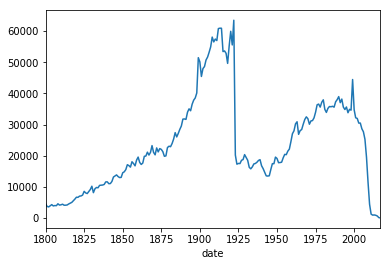

In [31]:
all_years.plot()
#allow_years.plot()
#deny_years.plot()

In [19]:
ongoing = full[(full.date == 9999)].groupby('date')['id'].count()
ongoing_a = full[(full.date == 9999) & (full.access == 'allow')].groupby('date')['id'].count()
ongoing_d = full[(full.date == 9999) & (full.access == 'deny')].groupby('date')['id'].count()

print ("There are %s ongoing publications according to the Hathifiles" % ongoing.iloc[0])
print ("There are %s ongoing publications that are openly available according to the Hathifiles" % ongoing_a.iloc[0])
print ("There are %s ongoing publications that re 'Limited View' according to the Hathifiles" % ongoing_d.iloc[0])

There are 196345 ongoing publications according to the Hathifiles
There are 91847 ongoing publications that are openly available according to the Hathifiles
There are 104498 ongoing publications that re 'Limited View' according to the Hathifiles


In [40]:
#This merges the metadata extracted from the Hathifiles with the top counts from the analytics,
#and spits out the list of the most viewed items in HathiTrust
#But this could easily be tweaked to show top NYPL items, top items that were denied access (excellent ILL candidates),
#top items published in a given country, etc. 
counts_ids = full.merge(counts, on='id', suffixes=['_full','_counts'])
counts_ids.sort_values('count', ascending=False).head(100)

,id,title,access,date,oclc,count
105427,mdp.39015054061430,"Quicksand, by Nella Larsen.",allow,1928.0,7332881,101702
75199,mdp.39015011274175,"The surnames of Scotland, their origin meaning...",allow,1962.0,1724215,69754
65550,mdp.39015004111095,Godey's magazine.,allow,1850.0,2133694,55418
172780,pst.000057937434,The human figure / by John H. Vanderpoel.,allow,1907.0,3095972,48835
61310,mdp.39015000804453,Perfume and flavor materials of natural origin.,allow,1960.0,1493297,48363
111279,mdp.39015064340733,"Solid mensuration, by Willis F. Kern and James...",allow,1934.0,823935,44557
61058,mdp.39015000566789,"America is in the heart, a personal history, b...",allow,1946.0,326807,41721
71062,mdp.39015008158415,Quintus Curtius [History of Alexander] with an...,allow,1946.0,685637,38700
189012,uc1.32106007458745,History of wages in the United States from Col...,allow,1934.0,2794726,38244
99427,mdp.39015038069475,"Return to life through contrology, by Joseph H...",allow,1960.0,3165474,31078


In [22]:
#This grabs dates from the postgres DB to some data analysis and historgrams, etc.

all_dates = x = pd.read_sql_query("SELECT DISTINCT publication_date, count(publication_date) \
           from hathifiles GROUP BY publication_date ORDER BY publication_date ASC", con=con)
all_dates_a = x = pd.read_sql_query("SELECT DISTINCT publication_date, count(publication_date) \
           from hathifiles WHERE access = 'allow' GROUP BY publication_date ORDER BY publication_date ASC", con=con)

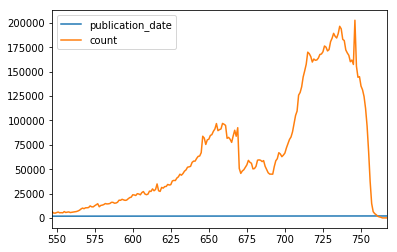

In [25]:
dates = all_dates[(all_dates.publication_date < 2021) & (all_dates.publication_date > 1799)]
dates_a = all_dates_a[(all_dates_a.publication_date < 2018) & (all_dates_a.publication_date > 1799)]
dates.plot()

In [33]:
#dates.index = dates.publication_date
dates_a.index = dates_a.publication_date
#dates.loc[:,'accessed'] = all_years
dates_a.loc[:,'accessed'] = allow_years
dates_a

,publication_date,count,accessed
publication_date,,,
1800.0,1800.0,6303,4552
1801.0,1801.0,5044,3696
1802.0,1802.0,4917,3535
1803.0,1803.0,5526,3918
1804.0,1804.0,6044,4276
1805.0,1805.0,5275,3859
1806.0,1806.0,5421,3981
1807.0,1807.0,5243,3938
1808.0,1808.0,6491,4547


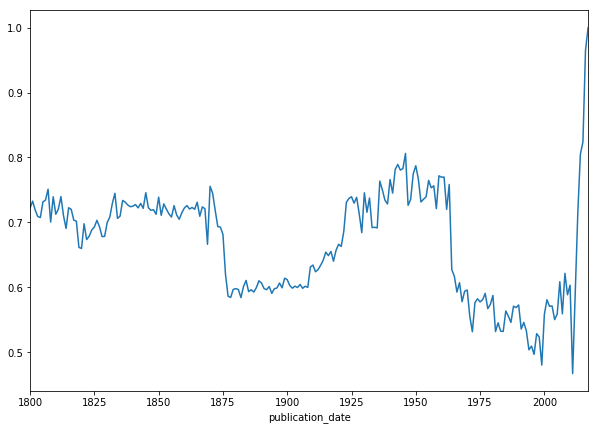

In [34]:
#util = dates.accessed / dates['count']
util_a = dates_a.accessed / dates_a['count']
util_a
#util.plot()
util_a.plot(figsize=(10,7))

(0, 1)

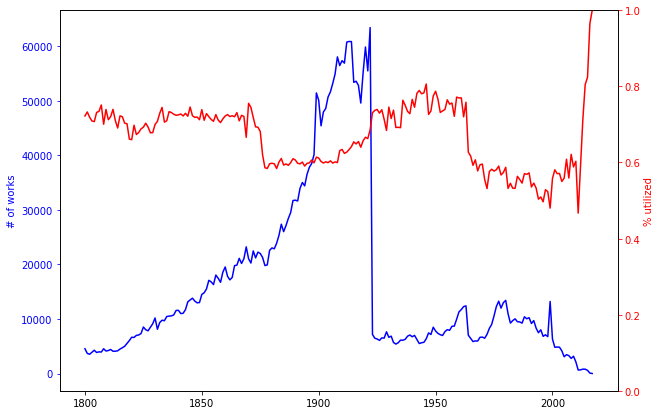

In [35]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(allow_years, color='b')
ax1.set_ylabel('# of works', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(util_a, color='r')
ax2.set_ylabel('% utilized', color='r')
ax2.tick_params('y', colors='r')
ax2.set_ylim([0,1])

In [36]:
pdata = pd.DataFrame()

pdata.loc[:, 'all'] = all_years 
#pdata.loc[:, 'accessed'] = allow_years
#pdata.loc[:, 'denied'] = deny_years

In [37]:
pdata['all'] = pdata['all'].astype(float)
#pdata.to_csv('./csv/all_years_data.csv')

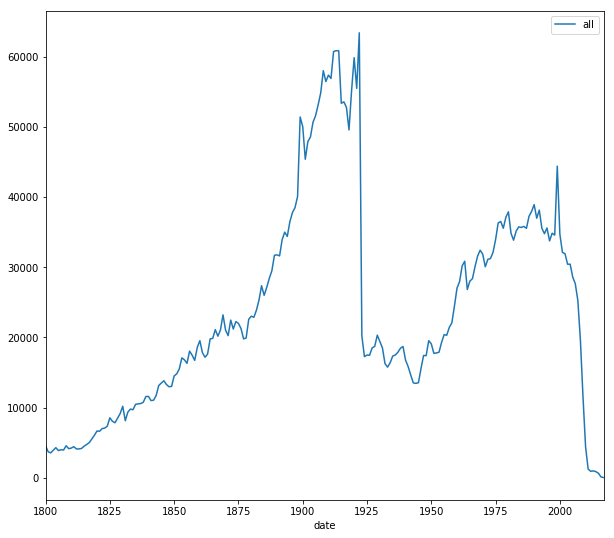

In [39]:
pdata.plot(figsize=(10,9))

For comparison, here is the distribution of all publications in WorldCat, as estimates by Brian Lavoie and Lorcan Dempsey in an 2009 D-Lib article titled ["Beyond 1923: Characteristics of Potentially In-copyright Print Books in Library Collections"](http://www.dlib.org/dlib/november09/lavoie/11lavoie.html)

![Year distribution of all publications from WorldCat](https://www.journalofelectronicpublishing.org/images/3336451.0009.208-00000004.jpg)


In [1]:
# Fun for later: 
# #To extract all possible search queries from the analytics

# def queries():
#     #This will extract 
#     #Note: this extract only the first match of the pattern in the source string, but for our purposes this should be both fine and correct
#     pattern = '(?P<Query>q1=[^\&\n\|]*|lookfor=[^\&\n\|]*)'
#     t = df['ga:pagePath'].str.extract(pattern, expand=True)
#     df_queries = t[t['Query'].notnull()]
#     df_queries.to_csv('./csv/queries.csv', index=False)
# # %time queries()

In [2]:
#Embed HathiTrust word cloud here

![HathiTrust search query word cloud](./img/hathi_search_queries.png)